In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.ndimage as spnd

import utils as ut
import plot as pt
plt.rcParams.update({'font.size': 12,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'legend.frameon':    False,})

%load_ext autoreload
%autoreload 2

### 1. Choose which dataset to use

 All datasets must be in the "datasets" folder.

In [2]:
# filename = "SSTindivsomata_GLM"
filename = "NDNFindivsomata_GLM"
# filename = "EC_GLM"

filepath = os.path.join("datasets", filename+".mat")
activity_dict, factors_dict = ut.preprocess_data(filepath)
filtered_factors_dict = ut.subset_variables_from_data(factors_dict, variables_to_keep=["Velocity"])

# animal = 'animal_1'
# cell = 'cell_2'
# GLM_params, predicted_activity_dict = ut.fit_GLM(filtered_factors_dict[animal], activity_dict[animal][cell], regression='ridge')

GLM_params, predicted_activity_dict = ut.fit_GLM_population(filtered_factors_dict, activity_dict, quintile=None, regression='ridge', renormalize=True, alphas=None)
residual_activity_dict = ut.get_residual_activity_dict(activity_dict, predicted_activity_dict)


### Lick predictions

In [ ]:
# filename = "SSTindivsomata_GLM"
# filename = "NDNFindivsomata_GLM"
filename = "EC_GLM"

filepath = os.path.join("datasets", filename+".mat")
activity_dict, factors_dict = ut.preprocess_data(filepath)

filtered_factors_dict = ut.subset_variables_from_data(factors_dict, variables_to_keep=["Velocity"])
GLM_params, predicted_activity_dict = ut.fit_GLM_population(filtered_factors_dict, activity_dict, quintile=None, regression='linear', renormalize=True, alphas=None)
residual_activity_dict = ut.get_residual_activity_dict(activity_dict, predicted_activity_dict)


In [ ]:
# Get activity data in shape (trials x neurons x timebins)
animal = 'animal_4'

# SST 4,7
# NDNF 2,
# EC 4,1

neural_data = []
for cell, data in activity_dict[animal].items():
    neural_data.append(data.T)
neural_data = np.stack(neural_data, axis=1)

# behavior_data = []
# for behav_factor, data in factors_dict[animal].items():
#     behavior_data.append(data.T)
# behavior_data = np.stack(behavior_data, axis=1)

behavior_data = factors_dict[animal]['Licks']

animal_GLM_params, GLM_predicted_behavior = ut.fit_behavior_GLM(activity_dict[animal], behavior_data)
mse = np.sum((GLM_predicted_behavior - behavior_data)**2, axis=1) / GLM_predicted_behavior.shape[1]

plt.plot(mse)
plt.ylabel('Lick GLM prediction error (MSE)')
plt.xlabel('Trials')
plt.title(animal)

In [ ]:
def map_estimate(neural_data, lick_rate, prior_variance=1.0):
    """
    Computes the Maximum A Posteriori (MAP) estimate of lick rate given neural activity using Bayesian linear regression.

    Parameters:
    - neural_data: np.ndarray of shape (num_neurons, timepoints), neural activity over time.
    - lick_rate: np.ndarray of shape (timepoints,), observed lick rate over time.
    - prior_variance: float, variance of the Gaussian prior on W.

    Returns:
    - map_lick_rate: np.ndarray of shape (timepoints,), MAP estimate of lick rate.
    """

    num_neurons, timepoints = neural_data.shape

    # Compute MAP estimate of W
    X = neural_data  # (num_neurons, timepoints)
    y = lick_rate.reshape(1, -1)  # (1, timepoints)

    # Given a Gaussian prior on W, the MAP estimate of W is given by:
    # W_map = (X*X^T + lambda*I)^-1 * X * y
    # where lambda is prior precision (1/variance)

    lambda_I = prior_variance * np.eye(num_neurons)  # Compute covariance matrix of the prior
    W_map = np.linalg.inv(X @ X.T + lambda_I) @ X @ y.T  # (num_neurons, 1)

    # Compute predicted lick rate
    map_lick_rate = (W_map.T @ X).flatten()  # (timepoints,)

    return map_lick_rate

neural_data_flattened = neural_data.reshape(neural_data.shape[1], -1)
map_lick_rate = map_estimate(neural_data_flattened, behavior_data)

pearsonr = np.corrcoef(map_lick_rate, behavior_data.flatten())[0, 1]
print(f"pearson R: {pearsonr}")
# fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# ax[0].imshow(behavior_data.T, aspect='auto', cmap='gray_r')
# ax[0].vlines(25,0,num_trials, color='r')
# prediction = map_lick_rate.reshape(behavior_data.shape)
# ax[1].imshow(prediction.T, aspect='auto', cmap='gray_r')
# ax[1].vlines(25,0,num_trials, color='r')

In [ ]:
num_trials = behavior_data.shape[1]
lick_accuracy_list = []
lick_window = 1
reward_idx = 26
for trial in range(num_trials):
    licks_near_reward = behavior_data[reward_idx-lick_window:reward_idx+lick_window+1, trial]
    licks_before_reward = behavior_data[0:reward_idx-lick_window, trial]
    licks_after_reward = behavior_data[reward_idx+lick_window+1:, trial]
    lick_accuracy = licks_near_reward.sum() / (licks_near_reward.sum() + licks_before_reward.sum() + licks_after_reward.sum()+1e-5)
    lick_accuracy_list.append(lick_accuracy)

fig, ax  = plt.subplots(1,5, figsize=(14,5))
ax[0].imshow(behavior_data.T, cmap='gray_r', interpolation='none', aspect='auto')
ax[0].vlines(25,0,num_trials, colors='r')
ax[0].set_xlabel('Position')
ax[0].set_ylabel('Trial Number')

# plt.plot(lick_accuracy_list)
smoothed_lick_accuracy_list = spnd.gaussian_filter1d(lick_accuracy_list, sigma=1)
# smoothed_lick_accuracy_list = spnd.uniform_filter1d(lick_accuracy_list, size=5)
ax[1].plot(smoothed_lick_accuracy_list)
ax[1].set_xlabel('Trial Number')
ax[1].set_ylabel('Lick Accuracy')

pearsonr = np.corrcoef(behavior_data.flatten(), GLM_predicted_behavior.flatten())[0,1]
ax[2].imshow(GLM_predicted_behavior.T, cmap='gray_r', interpolation='none', aspect='auto')
ax[2].set_xlabel('Position')
ax[2].set_ylabel('Trial Number')
ax[2].vlines(25,0,num_trials, colors='r')
ax[2].set_title(f'GLM Lick Prediction,\nR={pearsonr:.2f}')

prediction = map_lick_rate.reshape(behavior_data.shape)
pearsonr = np.corrcoef(behavior_data.flatten(), prediction.flatten())[0,1]
ax[3].imshow(prediction.T, cmap='gray_r', interpolation='none', aspect='auto')
ax[3].set_xlabel('Position')
ax[3].set_ylabel('Trial Number')
ax[3].vlines(25,0,num_trials, color='r')
ax[3].set_title(f'Bayesian Estimator,\nR={pearsonr:.2f}')

avg_prediction = (GLM_predicted_behavior + prediction)/2
pearsonr = np.corrcoef(behavior_data.flatten(), avg_prediction.flatten())[0,1]
avg_prediction = (avg_prediction - avg_prediction.min())/(avg_prediction.max() - avg_prediction.min())
ax[4].imshow(avg_prediction.T, cmap='gray_r', interpolation='none', aspect='auto')
ax[4].set_xlabel('Position')
ax[4].set_ylabel('Trial Number')
ax[4].vlines(25,0,num_trials, color='r')
ax[4].set_title(f'Average prediction,\nR={pearsonr:.2f}')
cbar = plt.colorbar(ax[4].images[0], ax=ax[4])

plt.suptitle(f"{filename[0:4]}, Animal {animal.split('_')[-1]}")
plt.tight_layout()
plt.show()


In [ ]:
# Get activity data in shape (trials x neurons x timebins)
print(activity_dict.keys())
# animal = 'animal_1'

neural_data = []
for cell, data in activity_dict[animal].items():
    neural_data.append(data.T)
neural_data = np.stack(neural_data, axis=1)

behavior_data = []
for behav_factor, data in factors_dict[animal].items():
    behavior_data.append(data.T)
behavior_data = np.stack(behavior_data, axis=1)

print(f"num neurons: {neural_data.shape[1]}")
num_trials = neural_data.shape[0]
num_neurons = min(neural_data.shape[1], 15)

fig, ax = plt.subplots(1,num_neurons+2, figsize=(20,6))
ax[0].imshow(behavior_data[:,0,:], cmap='gray_r', interpolation='none')
ax[0].set_ylabel('trial')
ax[0].set_title('Licks', fontsize=12)
ax[1].imshow(behavior_data[:,2,:], cmap='inferno', interpolation='none')
ax[1].set_title('Velocity', fontsize=12)
ax[1].set_yticks([])
for n in range(num_neurons):
    ax[n+2].imshow(neural_data[:,n], cmap='magma', interpolation='none')
    # ax[n].vlines(reward_loc, 0, num_trials, color='r', linestyle='--')
    ax[n+2].set_title('Neuron {}'.format(n), fontsize=12)
    ax[n+2].set_yticks([])
plt.tight_layout()
plt.show()


In [ ]:
neural_data = []
for cell, data in residual_activity_dict[animal].items():
    neural_data.append(data.T)
neural_data = np.stack(neural_data, axis=1)

fig, ax = plt.subplots(1,num_neurons+1, figsize=(20,6))
ax[0].imshow(behavior_data[:,0,:], cmap='gray_r', interpolation='none')
ax[0].set_ylabel('trial')
ax[0].set_title('Licks, '+f"{filename[0:3]} Animal {animal.split('_')[-1]}", fontsize=12)
# ax[0].set_title('Licks', fontsize=12)
# ax[1].imshow(behavior_data[:,2,:], cmap='bwr', interpolation='none')
# ax[1].set_title('Velocity', fontsize=12)
# ax[1].set_yticks([])
for n in range(num_neurons):
    ax[n+1].imshow(neural_data[:,n], cmap='magma', interpolation='none')
    ax[n+1].set_title('Neuron {}'.format(n), fontsize=12)
    ax[n+1].set_yticks([])
plt.tight_layout()
plt.show()


In [ ]:
# Cluster/Sort neurons based on their similarity to each other 

# 1. Plot cosine similarity matrix (neural_data.shape = (n_neurons, n_timepoints))

neural_data = neural_data.reshape(neural_data.shape[1], -1)
lick_rate = behavior_data.flatten()

print(neural_data.shape, lick_rate.shape)

### Factor Analysis

In [ ]:
def factor_analysis_em(X, num_factors, max_iter=100, tol=1e-6):
    """
    Perform Factor Analysis using the EM algorithm.
    
    Parameters:
        X: np.ndarray
            Data matrix (n_samples x n_features).
        num_factors: int
            Number of latent factors.
        max_iter: int
            Maximum number of iterations.
        tol: float
            Convergence tolerance.
    
    Returns:
        W: np.ndarray
            Loadings matrix (n_features x num_factors).
        Psi: np.ndarray
            Diagonal noise covariance matrix (n_features x n_features).
        Z_post: np.ndarray
            Posterior latent variables (n_samples x num_factors).
    """
    n_samples, n_features = X.shape

    # Initialize W (randomly) and Psi (diagonal variance)
    W = np.random.randn(n_features, num_factors)
    Psi = np.var(X, axis=0)  # Store Psi as a 1D array for the diagonal values

    for iteration in range(max_iter):
        # E-step: Compute posterior expectations
        Psi_inv = np.linalg.inv(np.diag(Psi))  # Use Psi as a diagonal matrix
        M = np.linalg.inv(W.T @ Psi_inv @ W + np.eye(num_factors))
        Z_post = X @ Psi_inv @ W @ M
        ZZ_post = n_samples * M + Z_post.T @ Z_post

        # M-step: Update W and Psi
        W_new = (X.T @ Z_post) @ np.linalg.inv(ZZ_post)
        Psi_new_diag = np.mean((X - Z_post @ W_new.T) ** 2, axis=0)  # Update diagonal of Psi

        # Convergence check
        if np.linalg.norm(W - W_new) < tol:
            break
        W = W_new
        Psi = Psi_new_diag  # Update only the diagonal values
    
    # Return Psi as a diagonal matrix
    return W, np.diag(Psi), Z_post

# Generate synthetic data
np.random.seed(42)
true_W = np.array([[0.8, 0.3], [0.4, 0.9], [0.6, 0.7]])
true_Psi = np.diag([0.1, 0.2, 0.3])
n_samples = 500
Z_true = np.random.randn(n_samples, 2)
X = Z_true @ true_W.T + np.random.multivariate_normal([0, 0, 0], true_Psi, n_samples)

# Run FA
W, Psi, Z_post = factor_analysis_em(X, num_factors=2)

print("Learned W:\n", W)
print("Learned Psi:\n", Psi)

In [ ]:
animal = 'animal_2'

velocity = factors_dict[animal]['Velocity']
activity_matrix = []
for cell in residual_activity_dict[animal]:
    activity_matrix.append(residual_activity_dict[animal][cell])
num_cells = len(residual_activity_dict[animal])
num_timepoints = residual_activity_dict[animal][cell].shape[0]
num_trials = residual_activity_dict[animal][cell].shape[1]
activity_matrix = np.array(activity_matrix)
activity_matrix = activity_matrix.reshape((activity_matrix.shape[0], activity_matrix.shape[1]*activity_matrix.shape[2])).T

print(f'Animal: {animal}')
print(f'Number of cells: {num_cells}')
print(f'Number of timepoints: {num_timepoints}')
print(f'Number of trials: {num_trials}')

In [ ]:
activity_matrix.shape

In [ ]:
# W, Psi, Z_post = factor_analysis_em(activity_matrix, num_factors=2)

In [ ]:
from sklearn.decomposition import FactorAnalysis

# Initialize FA model
num_factors = 3  # Number of latent factors
fa = FactorAnalysis(n_components=num_factors)

# Fit and transform the data
Z = fa.fit_transform(activity_matrix)

# Extract the loadings matrix and noise covariance
W = fa.components_.T
Psi = fa.noise_variance_

In [ ]:
plt.scatter(range(len(Psi)), Psi)

In [ ]:
Z.shape

In [ ]:
# Assume Z is (n_samples, n_factors)
for i in range(Z.shape[1]):
    plt.plot(Z[:, i], label=f'Factor {i + 1}')

# plt.xlim(0, 100)

plt.xlabel('Samples (Trials or Time Points)')
plt.ylabel('Latent Factor Value')
plt.title('Latent Factor Dynamics')
plt.legend()
plt.show()


In [ ]:
factor_1 = Z[:, 0].reshape(num_timepoints, num_trials)
factor_2 = Z[:, 1].reshape(num_timepoints, num_trials)
factor_3 = Z[:, 2].reshape(num_timepoints, num_trials)

fig, ax = plt.subplots(1,3, figsize=(8,5))
ax[0].imshow(factor_1.T)
ax[0].set_title('Factor 1')
ax[1].imshow(factor_2.T)
ax[1].set_title('Factor 2')
ax[2].imshow(factor_3.T)
ax[2].set_title('Factor 3')
# ax[2].imshow(velocity.T, cmap='gray')
# ax[2].set_title('Velocity')
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(np.mean(factor_1, axis=1), color='red', label='Factor 1')
plt.plot(np.mean(factor_2, axis=1), color='blue', label='Factor 2')
plt.plot(np.mean(factor_3, axis=1), color='k', label='Factor 3')
# plt.plot(np.mean(velocity, axis=1), color='k', label='Velocity')
plt.legend()
plt.xlabel('Position')

In [ ]:
plt.plot(np.mean(factor_1, axis=0), color='red')
plt.plot(np.mean(factor_2, axis=0), color='blue')
plt.plot(np.mean(factor_3, axis=0), color='k')
plt.xlabel('Trials')

In [ ]:
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize, to_rgba

trial = 420
fig, ax = plt.subplots()

# for trial in range(5):
# Create line segments
x = factor_1[:, trial]
y = factor_2[:, trial]
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a LineCollection with a colormap
cmap = plt.get_cmap('viridis')  # Choose your colormap
colors = np.linspace(0, 1, factor_1.shape[0])  # Gradient values (e.g., 0 to 1)
norm = Normalize(vmin=0, vmax=1)
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(colors)  # Apply gradient
lc.set_linewidth(2)  # Adjust line width

# Plot
ax.add_collection(lc)
ax.scatter(x[0], y[0], color='blue', label='Start')
ax.scatter(x[25], y[25], color='red', label='Reward', zorder=10, marker='*', s=300)
ax.arrow(x[-1], y[-1], (x[-1]-x[-2])/100, (y[-1]-y[-2])/100, head_width=0.1, head_length=0.1, fc='r', ec='r')

ax.autoscale()  # Adjust axis limits to fit the data
# ax.set_xlim(x.min(), x.max())
# ax.set_ylim(y.min(), y.max())

# cbar = plt.colorbar(lc, ax=ax)
# cbar.set_label('Gradient')

plt.xlabel('Latent Factor 1')
plt.ylabel('Latent Factor 2')
plt.show()



In [ ]:
import plotly.graph_objects as go

trial = 0

x = factor_1[:, trial]
y = factor_2[:, trial]
z = factor_3[:, trial]
colors = np.linspace(0, 1, factor_1.shape[0])  # Gradient

reward_index = 25
reward_x = x[reward_index]
reward_y = y[reward_index]
reward_z = z[reward_index]

# Plotly 3D line with gradient
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=x, y=y, z=z,
    mode='lines',
    line=dict(
        color=colors,
        colorscale='Viridis',
        width=5
    )
))

# Add a red point at the reward location
fig.add_trace(go.Scatter3d(
    x=[reward_x], y=[reward_y], z=[reward_z],
    mode='markers',
    marker=dict(
        color='red',
        size=8,
        symbol='circle'
    ),
    name='Reward Location'
))

# Style and layout
fig.update_layout(
    title='3D Gradient Line (Interactive)',
    scene=dict(
        xaxis_title='Factor 1',
        yaxis_title='Factor 2',
        zaxis_title='Factor 3',
    ),
    margin=dict(l=0, r=0, b=0, t=40),
)

fig.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

trial = 2

colors = np.linspace(0, 1, factor_1.shape[0])  # Gradient
x = factor_1[:, trial]
y = factor_2[:, trial]
z = factor_3[:, trial]

# Create figure and 3D axis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Add the 3D gradient line
for i in range(len(x) - 1):
    ax.plot(
        [x[i], x[i + 1]],
        [y[i], y[i + 1]],
        [z[i], z[i + 1]],
        color=plt.cm.viridis(colors[i]),
        linewidth=2
    )

reward_idx = 25
ax.scatter(x[reward_idx], y[reward_idx], z[reward_idx], color='red', s=100, label='Reward')

# Set labels
ax.set_xlabel('Factor 1')
ax.set_ylabel('Factor 2')
ax.set_zlabel('Factor 3')

# Define the rotation function
def rotate(angle):
    ax.view_init(elev=30, azim=angle)

# Create animation
anim = FuncAnimation(fig, rotate, frames=np.arange(0, 360, 2), interval=50)

from IPython.display import HTML
HTML(anim.to_jshtml())


In [ ]:
from sklearn.cluster import KMeans

# Cluster neurons based on W
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(W)

# Visualize cluster assignments
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(W[:, 0], W[:, 1], c=clusters, cmap='viridis', s=50)
ax[0].set_xlabel('Factor 1')
ax[0].set_ylabel('Factor 2')
ax[1].scatter(W[:, 0], W[:, 2], c=clusters, cmap='viridis', s=50)
ax[1].set_xlabel('Factor 1')
ax[1].set_ylabel('Factor 3')
fig.suptitle('Neuron Clustering Based on Loadings')

# plt.scatter(W[:, 0], W[:, 1], c=clusters, cmap='viridis', s=50)
# plt.xlabel('Factor 1')
# plt.ylabel('Factor 2')
# plt.title('Neuron Clustering Based on Loadings')
# plt.show()


In [ ]:
# Compute reconstructed data
X_recon = Z @ W.T

# Compute error
X = activity_matrix
reconstruction_error = np.mean((X - X_recon) ** 2)

print(f"Reconstruction Error: {reconstruction_error:.4f}")

plt.scatter(X.flatten(), X_recon.flatten(), alpha=0.5)
plt.xlabel('Original Data')
plt.ylabel('Reconstructed Data')
plt.title('Original vs. Reconstructed Data')
plt.show()


X = activity_matrix.reshape(num_timepoints, num_trials, num_cells)
X_recon = X_recon.reshape(num_timepoints, num_trials, num_cells)

cell = 6
avg_cell = np.mean(X[:, :, cell], axis=1)
avg_recon = np.mean(X_recon[:, :, cell], axis=1)
plt.plot(avg_cell, label='Original', color='gray')
plt.plot(avg_recon, label='Reconstructed', color='gray', linestyle='dashed')

In [ ]:
# Cluster the trials in the latent space (to find 'attractor states' of similar trials)

from sklearn.cluster import KMeans

# Assume Z is your latent factor matrix of shape (num_trials x num_latent_factors)
num_clusters = 3  # Number of clusters (adjust based on your hypothesis or analysis)

reshaped_factors = Z.reshape(num_timepoints, num_trials, num_factors)
trial_mean = np.mean(reshaped_factors, axis=0)

# Perform K-means clustering on the latent factors
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(trial_mean)

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].scatter(trial_mean[:, 0], trial_mean[:, 1], c=cluster_labels, cmap='viridis')
ax[0].set_xlabel('Latent Factor 1')
ax[0].set_ylabel('Latent Factor 2')
ax[1].scatter(trial_mean[:, 0], trial_mean[:, 2], c=cluster_labels, cmap='viridis')
ax[1].set_xlabel('Latent Factor 1')
ax[1].set_ylabel('Latent Factor 3')
fig.suptitle('Clustered Trials in Latent Space')

# ax[0].scatter(Z[:, 0], Z[:, 1], c=cluster_labels, cmap='viridis')
# ax[0].set_xlabel('Latent Factor 1')
# ax[0].set_ylabel('Latent Factor 2')
# ax[0].set_title('Clustered Trials in Latent Space')
# ax[1].scatter(Z[:, 0], Z[:, 2], c=cluster_labels, cmap='viridis')
# ax[1].set_xlabel('Latent Factor 1')
# ax[1].set_ylabel('Latent Factor 3')
# fig.suptitle('Clustered Trials in Latent Space')


# plt.scatter(Z[:, 0], Z[:, 1], c=cluster_labels, cmap='viridis')
# plt.xlabel('Latent Factor 1')
# plt.ylabel('Latent Factor 2')
# plt.title('Clustered Trials in Latent Space')
# plt.colorbar(label='Cluster')
# plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assume Z is your latent factor matrix of shape (num_trials x num_latent_factors)
# For simplicity, we use the first two factors (Factor 1 vs Factor 2)
factor1 = trial_mean[:, 0]
factor2 = trial_mean[:, 1]
factor3 = trial_mean[:, 2]

# Create an array for trial indices (or use any other trial-based information you have)
trial_indices = np.arange(trial_mean.shape[0])

# Scatter plot with trial indices as colors
plt.scatter(factor1, factor2, c=trial_indices, cmap='viridis', s=50)
plt.colorbar(label='Trial Index')  # Colorbar showing trial indices
plt.xlabel('Latent Factor 1')
plt.ylabel('Latent Factor 2')
plt.title('Scatterplot of Trials in Latent Factor Space')
plt.show()

### jPCA

In [ ]:
import jPCA
from jPCA.util import load_churchland_data, plot_projections

In [ ]:
animal = 'animal_5'

# datas = []
# for cell in activity_dict[animal]:
#     datas.append(activity_dict[animal][cell])

datas = []
for cell in activity_dict[animal]:
    datas.append(activity_dict[animal][cell])
datas = np.array(datas).swapaxes(0,2) # swap trials and cells
datas_list = [] # convert 1st dimension to a list of arrays
for i in range(datas.shape[0]):
    datas_list.append(datas[i])
datas = datas_list
datas = datas[0:5]

times = list(range(0, 50))

# Create a jPCA object
jpca = jPCA.JPCA(num_jpcs=6)

# Fit the jPCA object to data
(projected, 
 full_data_var,
 pca_var_capt,
 jpca_var_capt) = jpca.fit(datas, times=times, tstart=0, tend=49)

# Plot the projected data
# x_idx and y_idx control which columns of the data are shown.
# For example, to plot the second jPCA plane, use x_idx=2, y_idx=3
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_projections(projected, axis=axes[0], x_idx=0, y_idx=1, circles=True, arrows=True, arrow_size=0.02, circle_size=0.01)
plot_projections(projected, axis=axes[1], x_idx=2, y_idx=3, circles=True, arrows=True, arrow_size=0.02, circle_size=0.01)

axes[0].set_title("jPCA Plane 1")
axes[1].set_title("jPCA Plane 2")
plt.tight_layout()
plt.show()

### 2. sliceTCA analysis

In [3]:
import torch
import slicetca

In [4]:
# Get activity data in shape (trials x neurons x timebins)
animal = 'animal_1'

neural_data = []
for cell, data in residual_activity_dict[animal].items():
    neural_data.append(data.T)
neural_data = np.stack(neural_data, axis=1)

# behavior_data = []
# for behav_factor, data in factors_dict[animal].items():
#     behavior_data.append(data.T)
# behavior_data = np.stack(behavior_data, axis=1)
# behavior_data.shape

# smooth along time axis, using a Gaussian filter (sigma=2 with bin size 10 ms corresponds to 20 ms)
neural_data = spnd.gaussian_filter1d(neural_data, sigma=2, axis=-1)

# min-max scaling for each neuron for values between [0,1]
neural_data = np.array([d / d.max() for d in np.array([d - d.min() for d in neural_data])])
print(neural_data.shape)

(52, 14, 50)


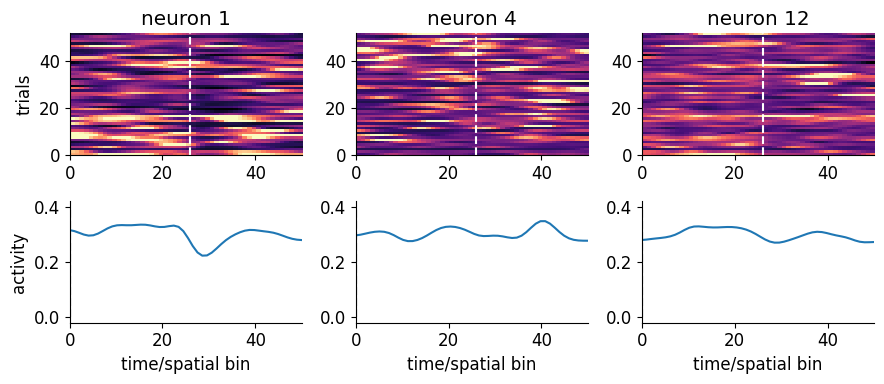

In [5]:
#### Plot raw data ####
neurons = [1,4,12]

plt.figure(figsize=(9,4), dpi=100)
# heat maps sorted by target angle for three example neurons
for ni,n in enumerate(neurons):
    plt.subplot(2,3,ni+1)
    plt.imshow(neural_data[:,n], aspect='auto', vmin=0, vmax=0.7, extent=[0,50, 0, len(neural_data)], cmap='magma', origin='lower', interpolation='none')
    plt.vlines(26, 0, len(neural_data), colors='w', linestyles='--')
    if ni==0: plt.ylabel('trials')
    plt.title('neuron ' + str(n))

# condition-averaged, scaled & smoothed PSTHs
for ni,n in enumerate(neurons):
    plt.subplot(2,3,ni+4)
    plt.plot(np.linspace(0,50,50), np.mean(neural_data[:,n], axis=0), '-')
    plt.plot([0,0], [0,.4], 'k--')
    if ni==0: plt.ylabel('activity')
    plt.xlim([0,50])
    plt.xlabel('time/spatial bin')
plt.tight_layout()

In [9]:
neural_data = np.random.randn(100, 14, 50)
neural_data.shape

(100, 14, 50)

In [ ]:
#### Run sliceTCA ####
device = ('cuda' if torch.cuda.is_available() else 'cpu')
neural_data_tensor = torch.tensor(neural_data, device=device, dtype=torch.float32)
# neural_data_tensor = neural_data_tensor/neural_data_tensor.std() # rescale data so it has similar magnitude as the initial weights
# print(neural_data_tensor.shape)

In [ ]:
#### Run sliceTCA ####
device = ('cuda' if torch.cuda.is_available() else 'cpu')
neural_data_tensor = torch.tensor(neural_data, device=device, dtype=torch.float32)
neural_data_tensor = neural_data_tensor/neural_data_tensor.std() # rescale data so it has similar magnitude as the initial weights
print(neural_data_tensor.shape)
components, model = slicetca.decompose(neural_data_tensor,
                                       number_components=(3,3,5), # (trials, neurons, time bins)
                                       # number_components=(3,0,0),
                                       positive=False,
                                       learning_rate=5*10**-3,
                                       min_std=10**-5,
                                       max_iter=3_000,
                                       seed=0)

plt.figure(figsize=(4,3), dpi=100)
plt.plot(np.arange(1000,len(model.losses)), model.losses[1000:], 'k')
plt.xlabel('iterations')
plt.ylabel('mean squared error')
plt.xlim(0,len(model.losses))
plt.tight_layout()

In [ ]:
# sort the neurons (in the trial slices) according to their peak activity in the first slice.
neuron_sorting_peak_time = np.argsort(np.argmax(components[0][1][0], axis=1))
axes = slicetca.plot(model,
              variables=('trial', 'neuron', 'time'),
            #   ticks=(None, None, np.linspace(0,50,3)), # we only want to modify the time ticks
            #   tick_labels=(None, None, np.linspace(0,50,3)),
            #   sorting_indices=(None, neuron_sorting_peak_time, None),
              quantile=0.99)

In [ ]:
model.__dict__.keys()

In [ ]:
model.vectors[0]

In [ ]:
# slice (trial/neuron/time), weights/heatmaps, component
x1 = model.vectors[0][0][0].detach().numpy()
x2 = model.vectors[0][0][1].detach().numpy()

plt.plot(x1, x2)

In [ ]:
#### Factor decoding from trial-slicing reconstruction ####

# Reconstruct the data from the fitted model
reconstruction_full = model.construct().numpy(force=True)
print(reconstruction_full.shape)

# reconstruct from the trial-slicing partition (i.e., sum of all trial-slicing component reconstructions)
reconstruction_trial_slicing = model.construct_single_partition(partition=0).numpy(force=True)

# construct from the time-slicing component(s)
reconstruction_time_slicing = model.construct_single_component(partition=2, k=0).numpy(force=True)


# map raw neural data vs. reconstructed data from the num_neuron-dimensional space to the num_factors-dimensional space of using OLS.
def OLS_projection(neurons, factors):
    """
    OLS function first reshapes the neural data to a (neurons x [trials * time]) matrix, and factors to a (coordinates x [trials * time]) matrix. 
    After mapping neural data to the factors, data is reshaped again to a tensor format.
    """

    # mapping onto x,y speed (instead of position) gives better fits
    factors = np.diff(factors, axis=-1)
    neurons = neurons[:,:,:-1]

    # reshape
    X = neurons.transpose(1,0,2).reshape(neurons.shape[1], -1).T
    X = np.concatenate([X, np.ones(len(X))[:,np.newaxis]], axis=1)
    Y = factors.transpose(1,0,2).reshape(factors.shape[1], -1).T

    # solve
    weights = np.linalg.pinv(X.T @ X) @ (X.T @ Y)

    # project and reshape
    Y_pred = (X @ weights).T

    # reshape back into original format
    Y_pred = Y_pred.reshape(factors.transpose(1,0,2).shape).transpose(1,0,2)

    # integrate along time axis
    Y_pred = np.cumsum(Y_pred, axis=-1)

    return Y_pred


# Plot decoded trajectories
# (actual factors vs the mapping of raw data onto the factors vs the mapping of the sliceTCA reconstruction from trial-slicing components)

# from raw data
mapping_raw = OLS_projection(neural_data[:,1:5,10:], behavior_data[:,1:5,10:]) #(trials, factors, timebins)

# from trial-slicing reconstruction
mapping_slicetca = OLS_projection(reconstruction_trial_slicing[:,1:5,10:], behavior_data[:,1:5,10:])

plot_names = ['factors', 'raw data', 'reconstruction from \ntrial-slicing']
data = [behavior_data[:,1:5,10:] - behavior_data[:,1:5,0][:,:,np.newaxis], mapping_raw, mapping_slicetca]
plt.figure(figsize=(9,3), dpi=100)
for di,d in enumerate(data):
    plt.subplot(1,3,di+1)
    for ti,t in enumerate(d):
        plt.plot(t[0], t[1])
    plt.title(plot_names[di])
plt.tight_layout()

In [ ]:
#### Cross-validation ####
# determine the number of components necessary to fit the tensor reconstructed from the slicetca model + some noise

train_mask, test_mask = slicetca.block_mask(dimensions=reconstruction_full.shape,
                                            train_blocks_dimensions=(1, 1, 10), # Note that the blocks will be of size 2*train_blocks_dimensions + 1
                                            test_blocks_dimensions=(1, 1, 5), # Same, 2*test_blocks_dimensions + 1
                                            fraction_test=0.1,
                                            device=device)

# Run a grid search to fit models with different numbers of components for (trial, neuron, time). 

reconstructed_noisy_tensor = torch.relu(torch.tensor(reconstruction_full, device=device)+torch.randn(reconstruction_full.shape, device=device)*0.1)

# this will take a while to run as it fits 3*3*8*4 = 288 models
loss_grid, seed_grid = slicetca.grid_search(reconstructed_noisy_tensor,
                                            min_ranks = [1, 1, 5],
                                            max_ranks = [3, 3, 8],
                                            sample_size=4,
                                            mask_train=train_mask,
                                            mask_test=test_mask,
                                            processes_grid=4,
                                            seed=1,
                                            min_std=10**-4,
                                            learning_rate=5*10**-3,
                                            max_iter=10_000,
                                            positive=True)

In [ ]:
slicetca.plot_grid(loss_grid, min_ranks=(1, 1, 5))


### 2. (Optional) Filter the data

Skip this code block if you want to include all neurons in the analysis.

For example, you can keep only the cells with GLM prediction R<sup>2</sup> > 0.8, or the top 20% of cells based on Velocity weights.

In [ ]:
data, GLM_params= filter_neurons_by_metric(data, GLM_params, variable_list, 
                                                       metric = 'R2',        # Options: 'R2', 'trial correlations', 'Licks', 'Reward_loc', 'Velocity', '#1', '#2', etc.
                                                       threshold = 0.5, 
                                                       scale_type = 'value', # Options: 'value', 'percentile', 'std'
                                                       keep = 'top'          # Options: 'top', 'bottom'
                                                       )


# data, GLM_params= filter_neurons_by_metric(data, GLM_params, variable_list, 
#                                                        metric = 'trial correlations',        # Options: 'R2', 'trial correlations', 'Licks', 'Reward_loc', 'Velocity', '#1', '#2', etc.
#                                                        threshold = 20, 
#                                                        scale_type = 'percentile', # Options: 'value', 'percentile', 'std'
#                                                        keep = 'top'          # Options: 'top', 'bottom'
#                                                        )

### 3. Visualize the data

The animal and cell numbers are based on your original dataset, so e.g. 'cell_1' does not exist because it has been removed from the data.

(Any cell with all zeros or all NaNs is automatically removed.)

In [ ]:
plot_combined_figure(reorganized_data, GLM_params, variable_list, model_name=filename, sort_by='R2', save=False)
# plot_combined_figure(reorganized_data, GLM_params, variable_list, model_name=filename, animal='animal_2', cell='cell_3', save=False)

In [ ]:
'''
If you want to visualize the GLM results for a specific example neuron, you can either specify the animal and cell number, 
or pick the top neuron based on a specific metric (such as weight for Reward_loc)
'''

plot_example_neuron(reorganized_data, GLM_params, variable_list, sort_by="Reward_loc")
plot_example_neuron(reorganized_data, GLM_params, variable_list, animal='animal_4', cell='cell_3')

In [ ]:
'''
Visualize the dF/F traces after subtracting the GLM prediction based on only Velocity (all other weights+intercept set to 0).
The dF/F data is Z-scored across all trials, and the 2 GLMs are trained on different subsets of this data.
You can compare any 2 quintiles of the data.
'''

plot_quintile_comparison(reorganized_data, variable_list, filename, quintiles=(1,5), save=False)

In [ ]:
avg_residuals, GLM_params = compute_velocity_subtracted_residuals(reorganized_data, variable_list, quintile=None)

In [ ]:
plt.imshow(avg_residuals, interpolation='none', aspect='auto', cmap='viridis')

In [ ]:
plt.plot(avg_residuals.T)
plt.show()

In [ ]:
plt.plot(avg_residuals.mean(axis=0))

In [ ]:
activity = reorganized_data['animal_2']['cell_8'][:,0,:].T
plt.imshow(activity, interpolation='none', aspect='auto', cmap='viridis')   

In [ ]:
cell = 19

avg_residuals, GLM_params = compute_velocity_subtracted_residuals(reorganized_data, variable_list, quintile=3)
sort_idx = np.argsort(np.argmax(avg_residuals, axis=1))
sorted_avg_residuals = avg_residuals[sort_idx]

# Renormalize between 0 and 1
cell_residual = sorted_avg_residuals[cell]
cell_residual = (cell_residual - np.min(cell_residual)) / (np.max(cell_residual) - np.min(cell_residual))

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].imshow(sorted_avg_residuals, aspect='equal', cmap='viridis', interpolation='none')
ax[0].set_xlabel('Position')
ax[0].set_ylabel('Cell')

ax[1].plot(cell_residual)
ax[1].set_xlabel('Position')
ax[1].set_ylabel('velocity-subtracted dF/F (Z-scored)')
ax[1].set_title(f"Cell {cell}")

plt.tight_layout()
plt.show()